In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import yfinance as yf
from sklearn.preprocessing import StandardScaler

In [75]:
# df = pd.read_csv('airline-passengers.csv')
df = yf.download('ETH-USD')
df = df.drop(['Adj Close','Volume'], axis='columns')
df.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2017-11-09,308.644989,329.451996,307.056,320.884003


In [76]:
# Adding daysofweek, weekofmonth and monthofyear to help the model identify seasonal patterns

# df['Day'] = df.index.dayofweek # 0 represents monday and 6 represents sunday
# df['Week'] = (df.index.day -1) // 7 +1 # days of month divided by 7 to get weeks
# df['Month'] = df.index.month #1 represents janurary and 12 represents december
# df.head(10)

In [77]:
timeseries_values = df.values.astype('float32')
# Normalize the data
scaler = StandardScaler()
timeseries = scaler.fit_transform(timeseries_values)
# Then, later, once we have predicted data, we can call scaler.inverse_transform(predicted_data)
# Print the scale so we get an idea of how much it was scaled by
print("Not scaled array: ", timeseries_values[0])
print("Scaled array: ",timeseries[0])

Not scaled array:  [308.645 329.452 307.056 320.884]
Scaled array:  [-0.8351531  -0.82473063 -0.8283941  -0.82508624]


In [78]:
# Choose how much past data a prediction is based on
seq_length = 50 # days
train_test_split_percentage = 0.75
batch_size = 16 # not optimized yet
feature_amount = timeseries[0].size #

# Define a function to create in/out sequence data
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-1):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq , train_label))
    return inout_seq

inout_seq = create_inout_sequences(timeseries, seq_length)

# Split data into train and test sets
train_size = int(len(inout_seq) * train_test_split_percentage)
train_set = inout_seq[:train_size]
test_set = inout_seq[train_size:]

# Convert inout_seq to tensors inside the list comprehension
train_data = data.TensorDataset(
    torch.stack([torch.FloatTensor(s[0]) for s in train_set]),
    torch.stack([torch.FloatTensor(s[1]) for s in train_set]))
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data = data.TensorDataset(
    torch.stack([torch.FloatTensor(s[0]) for s in test_set]),
    torch.stack([torch.FloatTensor(s[1]) for s in test_set]))
test_loader = data.DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [79]:
class StockPricePredictorLSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(StockPricePredictorLSTM, self).__init__()
        self.input_size = input_size
        # TODO: Increase the number of hidden layers
        self.hidden_layer_1_size = input_size*25
        self.hidden_layer_2_size = input_size*10
        self.hidden_layer_3_size = input_size*5
        self.output_size = output_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_layer_1_size, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.hidden_layer_1_size, self.hidden_layer_2_size)
        self.linear2 = nn.Linear(self.hidden_layer_2_size, self.hidden_layer_3_size)
        self.linear3 = nn.Linear(self.hidden_layer_3_size, self.output_size)

        # self.hidden_cell = (torch.zeros(1, batch_size,self.hidden_layer_size),
        #                     torch.zeros(1, batch_size, self.hidden_layer_size))

    def forward(self, input_seq):
        out, _ = self.lstm(input_seq)
        # lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        out = self.relu(out)
        out = self.linear(out[:,-1,:])
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out

# Initialize model
model = StockPricePredictorLSTM(input_size=feature_amount,output_size=feature_amount)
model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Train the model
epochs = 300
for i in range(epochs):
    # Size 32,10,4 and 32,1,4 respectively
    for seq, labels in train_loader:
        seq, labels = seq.cuda(), labels.view(-1, feature_amount).cuda()

        model.train()
        optimizer.zero_grad()
        # Reset the hidden state. Avoid using states across batches.
        # model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size).cuda(),
                            #  torch.zeros(1, seq.size(0), model.hidden_layer_size).cuda())

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    # Reduce the learning rate and increase the regularization as time goes on
    # It's kind of Gradient Descent
    if i == 100:
        for g in optimizer.param_groups:
          g['lr'] = 0.005
    elif i == 200:
        for g in optimizer.param_groups:
          g['lr'] = 0.0001
          g['weight_decay'] = 1e-4

    # Evaluate on the whole test set every 25 epochs
    if i%25 == 0:
        with torch.no_grad():
            model.eval()
            test_losses = []
            test_predictions = []

            # Iterate over test data
            for seq, labels in test_loader:
                seq, labels = seq.cuda(), labels.view(-1, feature_amount).cuda()
                y_pred = model(seq)
                test_predictions.append(test_predictions)
                test_loss = loss_function(y_pred, labels)
                test_losses.append(test_loss.item())
            # Report the average test loss
            avg_test_loss = np.mean(test_losses)
        print(f'epoch: {i:3} train loss: {loss.item():10.6f}, test loss: {avg_test_loss:10.8f}')

print(f'epoch: {i:3} train loss: {loss.item():10.6f} test loss: {avg_test_loss:10.8f}')

epoch:   0 train loss:   0.011779, test loss: 0.00821780
epoch:  25 train loss:   0.010303, test loss: 0.00271840
epoch:  50 train loss:   0.004336, test loss: 0.00408124
epoch:  75 train loss:   0.004112, test loss: 0.00224493
epoch: 100 train loss:   0.002738, test loss: 0.00323951
epoch: 125 train loss:   0.001936, test loss: 0.00420611
epoch: 150 train loss:   0.014463, test loss: 0.00178479
epoch: 175 train loss:   0.001493, test loss: 0.00435373
epoch: 200 train loss:   0.003804, test loss: 0.00205840
epoch: 225 train loss:   0.005553, test loss: 0.00177721
epoch: 250 train loss:   0.000456, test loss: 0.00177126
epoch: 275 train loss:   0.000066, test loss: 0.00175300
epoch: 299 train loss:   0.004016 test loss: 0.00175300


In [80]:
# Creating a function to predict n days ahead

def predict_n_days_ahead(n):
    # Move the model to evaluation mode
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        # We don't use the test_loader, because its easier to evaluate without the chunking
        seq = torch.stack([torch.FloatTensor(s[0]) for s in test_set]).cuda()
        # To predict n days in advance, we'll iterate and feed predictions back as input n times
        for i in range(n):
            preds = model(seq) # shape [test_size, feature_amount]
            preds = preds.unsqueeze(1) # shape [test_size, 1, feature_amount]
            # Now we can use add the prediction to the sequence
            seq = torch.cat((seq, preds), dim=1) # shape [test_size, seq_length + 1, feature_amount]
            # and drop the oldest sequence entry
            seq = seq[:, 1:, :] # shape [test_size, seq_length, feature_amount]
        final = np.array(preds.squeeze(1).cpu())
        return final


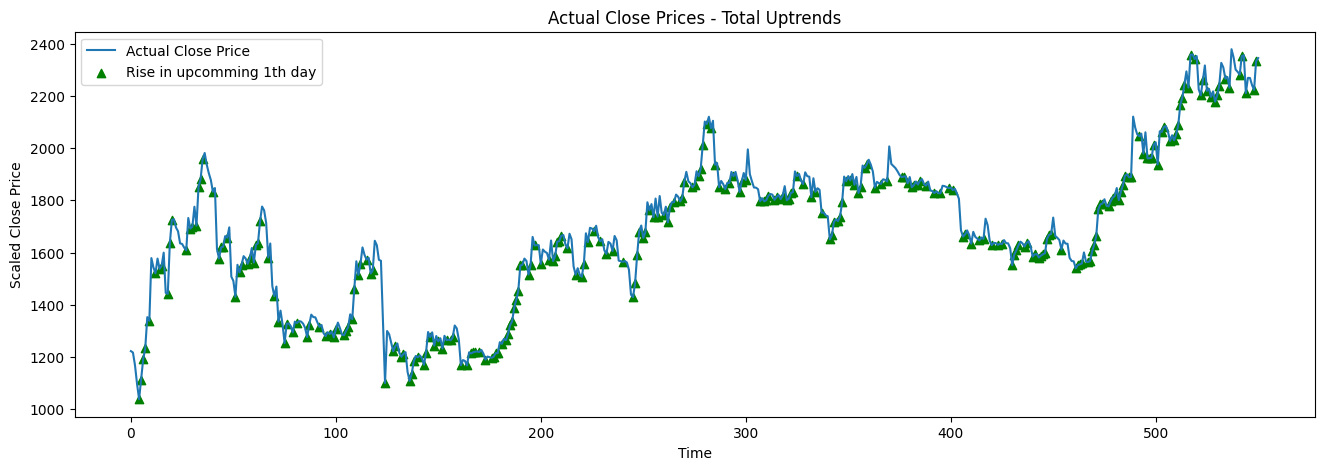

In [89]:
# Identifying and storing the total up-trends in the actual closing price of the testing data.

n_ahead = 5
n_gap = 1
empty_items = np.empty((n_ahead)) * np.nan
metric_to_look_at = 3 # 0 for Open, 1 for High, 2 for Low, 3 for Close

original = torch.stack([torch.FloatTensor(s[1]) for s in test_set])[:,-1,:] # X_test
denormalized = scaler.inverse_transform(original)
denormalized_close = denormalized[:,metric_to_look_at]
denormalized_actual_close = np.concatenate((denormalized_close, empty_items))

y_actual1 =[]
y_actual2 =[]

for i in range((len(denormalized_actual_close)) // n_gap):
  i= i * n_gap
  y_actual1.append(denormalized_actual_close[i])
  if (i < len(denormalized_actual_close)-n_gap):
    y_actual2.append( denormalized_actual_close[i+n_gap])
  elif (i == len(denormalized_actual_close)-n_gap):
    y_actual2.append( denormalized_actual_close[i+(n_gap-1)])
  # print(i)

y_actual_array1 = np.array(y_actual1)
y_actual_array2 = np.array(y_actual2)

y_actual_array1_nan = np.full((len(y_actual_array1) * (n_gap)), np.nan)
y_actual_array1_nan[::n_gap] = y_actual_array1

y_actual_array2_nan = np.full((len(y_actual_array2) * (n_gap)), np.nan)
y_actual_array2_nan[::n_gap] = y_actual_array2

actual_going_up_price = np.where(y_actual_array2_nan > y_actual_array1_nan, denormalized_actual_close, np.nan)
actual_going_up_days =[]
for i in range(len(actual_going_up_price)):
  actual_going_up_days.append(0+i)

plt.figure(figsize=(16,5))
plt.title('Actual Close Prices - Total Uptrends')
plt.xlabel('Time')
plt.ylabel('Scaled Close Price')
plt.plot(denormalized_actual_close, label=f'Actual Close Price')
plt.scatter(actual_going_up_days, actual_going_up_price, color='green', marker='^', label=f'Rise in upcomming {n_gap}th day')
plt.legend()
plt.show()

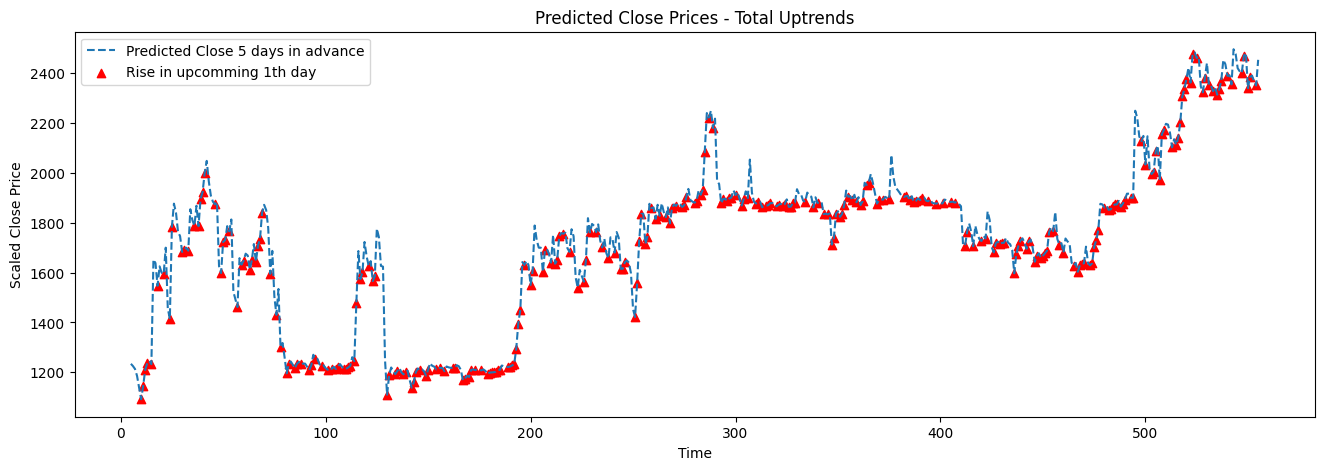

In [81]:
# Identifying and storing the total up-trends in the predicted close price made by the model

n_ahead = 5
n_gap = 1
empty_items = np.empty((n_ahead)) * np.nan
metric_to_look_at = 3 # 0 for Open, 1 for High, 2 for Low, 3 for Close

# Starts at prediction for day seq_length + n_ahead, so we pad the start
predicted_n_days = predict_n_days_ahead(n_ahead)
denormalized_predicted_n_days = scaler.inverse_transform(predicted_n_days)
denormalized_predicted_n_days_close = np.concatenate((empty_items, denormalized_predicted_n_days[:,metric_to_look_at]))

y_pred1 =[]
y_pred2 =[]

for i in range(((len(denormalized_predicted_n_days_close)) // n_gap)):
  i= i * n_gap
  y_pred1.append(denormalized_predicted_n_days_close[i])
  if (i < len(denormalized_predicted_n_days_close)- n_gap):
    y_pred2.append( denormalized_predicted_n_days_close[i+n_gap])
  elif (i == len(denormalized_predicted_n_days_close)- n_gap):
    y_pred2.append( denormalized_predicted_n_days_close[i+(n_gap-1)])
  # print(i)

y_pred_array1 = np.array(y_pred1)
y_pred_array2 = np.array(y_pred2)

y_pred_array1_nan = np.full((len(y_pred_array1) * (n_gap)), np.nan)
y_pred_array1_nan[::n_gap] = y_pred_array1

y_pred_array2_nan = np.full((len(y_pred_array2) * (n_gap)), np.nan)
y_pred_array2_nan[::n_gap] = y_pred_array2

pred_going_up_price = np.where(y_pred_array2_nan > y_pred_array1_nan, denormalized_predicted_n_days_close, np.nan)
pred_going_up_days =[]
for i in range(len(pred_going_up_price)):
  pred_going_up_days.append(0+i)

plt.figure(figsize=(16,5))
plt.title(f'Predicted Close Prices - Total Uptrends')
plt.xlabel('Time')
plt.ylabel('Scaled Close Price')
plt.plot(denormalized_predicted_n_days_close, label=f'Predicted Close {n_ahead} days in advance', linestyle='--')
plt.scatter(pred_going_up_days, pred_going_up_price, color='red', marker='^', label=f'Rise in upcomming {n_gap}th day')
plt.legend()
plt.show()

In [90]:
# Getting and storing the days where the up-trend is accurately predicted

accurate_rise_days =[]
for i in range(len(pred_going_up_price)):
  # np.isnan returns False if value is not a NAN value
  if( np.isnan(pred_going_up_price[i]) == False and np.isnan(actual_going_up_price[i]) == False):
    accurate_rise_days.append(i)

total_pred_rise_days = []
for i in range(len(pred_going_up_price)):
  if( np.isnan(pred_going_up_price[i]) == False):
    total_pred_rise_days.append(i)

Percentage_of_accurate_uptrends = (len(accurate_rise_days) / len(total_pred_rise_days)) * 100

# Printing the data to get a sense of what is actually happening here
print(f'Amount of total prediction days: {len(denormalized_predicted_n_days_close)}')
print(f'Amount of total upwards-trend prediction: {len(total_pred_rise_days)}')
print(f'Amount of accurate upwards-trend prediction: {len(accurate_rise_days)}')
print(f'Percentage of accurate upwards-trend prediction: {Percentage_of_accurate_uptrends:10.6f}%')

Amount of total prediction days: 556
Amount of total upwards-trend prediction: 276
Amount of accurate upwards-trend prediction: 141
Percentage of accurate upwards-trend prediction:  51.086957%


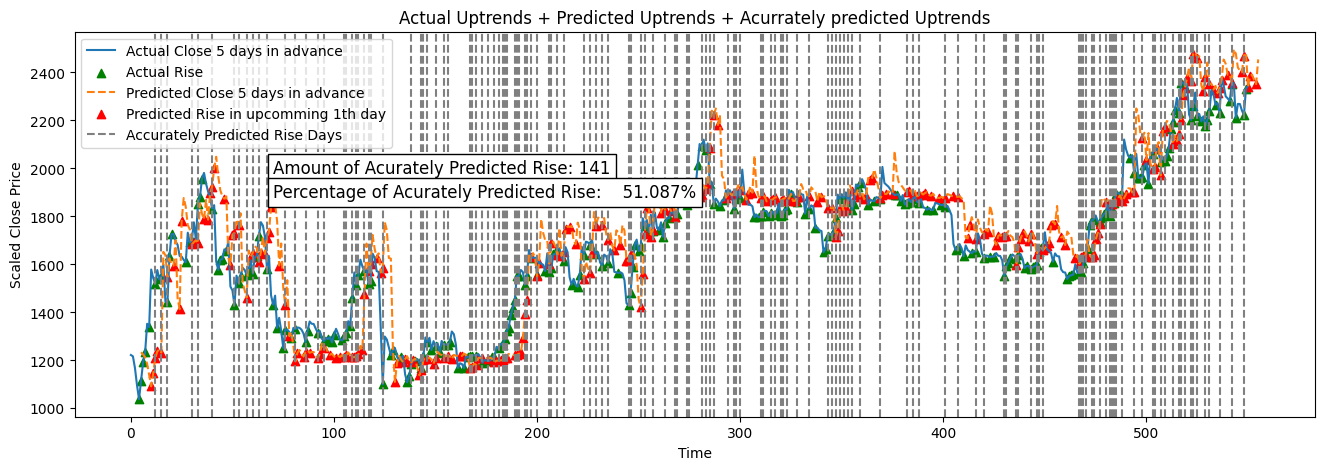

In [92]:
# Plotting the actual uptrends and predicted up trends and the accurately predicted up trends in one ultimate graph
# Don't get confused only look at the gray verticle lines: which are the accurately predicted up trends

plt.figure(figsize=(16,5))
plt.title(f'Actual Uptrends + Predicted Uptrends + Acurrately predicted Uptrends')
plt.xlabel('Time')
plt.ylabel('Scaled Close Price')
plt.plot(denormalized_close, label=f'Actual Close {n_ahead} days in advance')
plt.scatter(actual_going_up_days, actual_going_up_price, color='green', marker='^', label=f'Actual Rise')
plt.plot(denormalized_predicted_n_days_close, label=f'Predicted Close {n_ahead} days in advance', linestyle='--')
plt.scatter(pred_going_up_days, pred_going_up_price, color='red', marker='^', label=f'Predicted Rise in upcomming {n_gap}th day')
for day in accurate_rise_days:
  if (day == accurate_rise_days[0]):
    plt.axvline(x=day, color='gray', linestyle='--', label="Accurately Predicted Rise Days")
  else:
    plt.axvline(x=day, color='gray', linestyle='--')
plt.text(70, 2000, f'Amount of Acurately Predicted Rise: {len(accurate_rise_days)}', fontsize=12, va='center', color='black', bbox=dict(facecolor='white', alpha=1))
plt.text(70, 1900, f'Percentage of Acurately Predicted Rise:{Percentage_of_accurate_uptrends:10.3f}%', fontsize=12, va='center', color='black', bbox=dict(facecolor='white', alpha=1))
plt.legend()
plt.show()

In [85]:
# n_ahead = 5
# empty_items = np.empty((n_ahead)) * np.nan
# metric_to_look_at = 3 # 0 for Open, 1 for High, 2 for Low, 3 for Close

# # Note that this starts at day seq_length of the test set, because of the chunking
# original = torch.stack([torch.FloatTensor(s[1]) for s in test_set])[:,-1,:] # This is our original y_test
# denormalized = scaler.inverse_transform(original)
# denormalized_close = np.concatenate((denormalized[:,metric_to_look_at], empty_items))

# # Starts at prediction for day seq_length + n_ahead, so we pad the start
# predicted_n_days = predict_n_days_ahead(n_ahead)
# denormalized_predicted_n_days = scaler.inverse_transform(predicted_n_days)
# denormalized_predicted_n_days_close = np.concatenate((empty_items, denormalized_predicted_n_days[:,metric_to_look_at]))

# X_cords =[]
# y_cords =[]
# for i in range(len(denormalized_predicted_n_days_close) // n_ahead):
#   i= i * n_ahead
#   y_cords.append(denormalized_predicted_n_days_close[i])
#   X_cords.append(i)

# plt.figure(figsize=(16,5))
# plt.title(f'Actual and Predicted Close Prices ({n_ahead} days in advance)')
# plt.xlabel('Time')
# plt.ylabel('Scaled Close Price')
# plt.plot(denormalized_close, label='Actual Close')
# plt.plot(denormalized_predicted_n_days_close, label=f'Predicted Close {n_ahead} days in advance', linestyle='--')
# plt.scatter(X_cords,y_cords, color='orange', marker='o', label=f'{n_ahead} days gap')
# plt.legend()
# plt.show()


In [86]:
# n_ahead = 5
# empty_items = np.empty((n_ahead)) * np.nan
# metric_to_look_at = 3

# # Note that this starts at day seq_length of the test set, because of the chunking
# original = torch.stack([torch.FloatTensor(s[0]) for s in test_set])[:,-1,:]
# denormalized = scaler.inverse_transform(original)
# denormalized_close = denormalized[:,metric_to_look_at]
# denormalized_price = np.concatenate((denormalized_close, empty_items))

# # Starts at prediction for day seq_length + n_ahead, so we pad the start
# predicted_n_days = predict_n_days_ahead(n_ahead)
# denormalized_predicted_n_days = scaler.inverse_transform(predicted_n_days)
# denormalized_predicted_n_days_close = denormalized_predicted_n_days[:,metric_to_look_at]
# denormalized_predicted_n_days_price = np.concatenate((empty_items , denormalized_predicted_n_days_close))

# going_up = np.where(denormalized_predicted_n_days_price > denormalized_price, denormalized_price, np.nan)
# non_nan_count = np.sum(~np.isnan(going_up))
# nan_count = np.sum(np.isnan(going_up))
# MAE_close = np.mean(np.abs(denormalized_predicted_n_days_close - denormalized_close))

# plt.figure(figsize=(16,5))
# plt.title(f'Rise/Fall predictions')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.plot(denormalized_price, label='Actual close > predicted close', color='blue')
# plt.plot(going_up, label=f'Actual close < predicted close', color='red')
# plt.plot(denormalized_predicted_n_days_price, label=f'Predicted Close {n_ahead} days in advance', linestyle='--', color='orange')
# plt.text(70, 2100, f'Number of rise: {non_nan_count}', fontsize=12, va='center', color='red')
# plt.text(70, 2000, f'Number of fall: {nan_count}', fontsize=12, va='center', color='blue')
# plt.text(70, 1900, f'MAE of close prices: {MAE_close}', fontsize=12, va='center', color='black')
# plt.legend()
# plt.show()
# # print(denormalized_predicted_n_days_price)

In [87]:
def extrapolate_n_days(sequence, n):
    # Move the model to evaluation mode
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for i in range(n):
            preds = model(sequence)
            sequence = torch.cat((sequence, preds.unsqueeze(1)), dim=1)
        return sequence

test_seqs = torch.stack([torch.FloatTensor(s[0]) for s in test_set]).cuda()

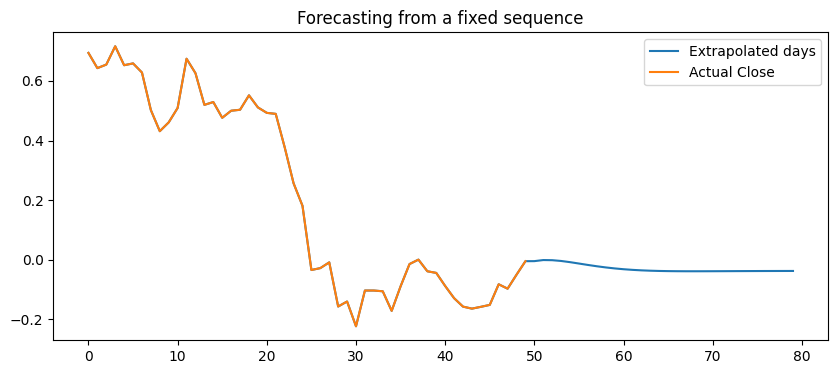

In [88]:
plt.figure(figsize=(10,4))
plt.title(f'Forecasting from a fixed sequence')
plt.plot(extrapolate_n_days(test_seqs[:1], 30).squeeze(0)[:,metric_to_look_at].cpu(), label='Extrapolated days')
plt.plot(np.array(test_seqs[:1].cpu()).squeeze(0)[:,metric_to_look_at], label='Actual Close')
plt.legend()
plt.show()